In [15]:
%pip install geoalchemy2 -q


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [3]:
# Cargar el archivo subido
df = pd.read_csv('./properties_20250601_142130.csv')

# Mostrar las primeras filas y el resumen de columnas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27495 entries, 0 to 27494
Data columns (total 66 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   estrato                        27494 non-null  float64
 1   area                           27495 non-null  int64  
 2   habitaciones                   27494 non-null  float64
 3   banos                          27494 non-null  float64
 4   parqueaderos                   27494 non-null  float64
 5   antiguedad                     27485 non-null  object 
 6   tipo_propiedad                 27495 non-null  object 
 7   tipo_operacion                 27495 non-null  object 
 8   latitud                        27495 non-null  float64
 9   longitud                       27495 non-null  float64
 10  localidad                      27495 non-null  object 
 11  barrio                         27352 non-null  object 
 12  precio_venta                   27495 non-null 

In [4]:
df.head()

,estrato,area,habitaciones,banos,parqueaderos,antiguedad,tipo_propiedad,tipo_operacion,latitud,longitud,...,2000_healthcare,2000_retail_access,2000_dining_and_entertainment,2000_accommodation,2000_parks_and_recreation,2000_infrastructure_services,2000_cultural_amenities,upz,catastral,comercial
0,3.0,76,3.0,2.0,1.0,ENTRE 10 Y 20 ANOS,APARTAMENTO,VENTA,4.746592,-74.057571,...,90,435,225,2,149,86,0,BRITALIA,2.003025e+06,3.035999e+06
1,3.0,63,3.0,2.0,0.0,MAS DE 20 ANOS,APARTAMENTO,VENTA,4.730111,-74.028170,...,133,421,225,2,43,142,3,SAN CRISTOBAL NORTE,1.589880e+06,2.213160e+06
2,3.0,54,3.0,2.0,0.0,ENTRE 0 Y 5 ANOS,APARTAMENTO,VENTA,4.607378,-74.082648,...,102,737,791,115,37,170,66,LA SABANA,1.454716e+06,1.691379e+06
3,2.0,43,2.0,2.0,0.0,ENTRE 10 Y 20 ANOS,APARTAMENTO,VENTA,4.740109,-74.113675,...,38,198,83,0,60,96,1,TIBABUYES,1.105646e+06,1.727753e+06
4,3.0,48,3.0,2.0,0.0,MAS DE 20 ANOS,APARTAMENTO,VENTA,4.763900,-74.025280,...,18,119,49,0,41,20,1,VERBENAL,8.312383e+05,1.225436e+06


In [5]:
df_clean = df.drop(columns=['precio_arriendo', 'closets'])

In [6]:
df_filtered = df_clean[df_clean['precio_venta'] < 20000000]

# Confirmar cuántos registros quedan
df_filtered.shape

(0, 64)

In [7]:
y = df_clean['precio_venta']
X = df_clean.drop(columns=['precio_venta'])

In [8]:
# Identificar columnas numéricas y categóricas
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['precio_venta']]

In [9]:

# Pipeline para preprocesamiento
numeric_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Crear pipeline completo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_estimators=100))
])

# Separar datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)



,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [10]:
# Extraer importancia de variables
rf_model = model.named_steps['regressor']
encoded_feature_names = model.named_steps['preprocessor'].get_feature_names_out()
feature_importances = rf_model.feature_importances_

# Crear DataFrame de importancia
importance_df = pd.DataFrame({
    'feature': encoded_feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)


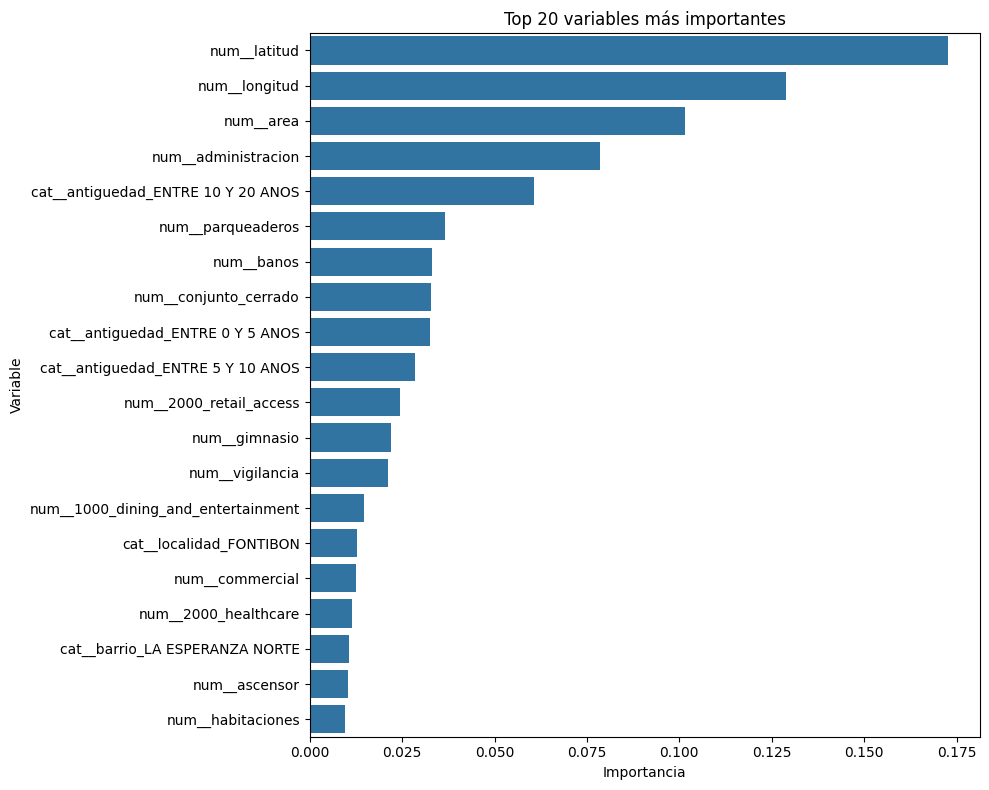

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar las N variables más importantes
top_n = 20
top_features = importance_df.head(top_n)

# Gráfico de barras
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 20 variables más importantes')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

In [17]:
df_clean.columns

Index(['estrato', 'area', 'habitaciones', 'banos', 'parqueaderos',
       'antiguedad', 'tipo_propiedad', 'tipo_operacion', 'latitud', 'longitud',
       'localidad', 'barrio', 'precio_venta', 'administracion', 'gimnasio',
       'ascensor', 'piscina', 'conjunto_cerrado', 'salon_comunal', 'terraza',
       'vigilancia', '100_education', '100_healthcare', '100_retail_access',
       '100_dining_and_entertainment', '100_accommodation',
       '100_parks_and_recreation', '100_infrastructure_services',
       '100_cultural_amenities', '300_education', '300_healthcare',
       '300_retail_access', '300_dining_and_entertainment',
       '300_accommodation', '300_parks_and_recreation',
       '300_infrastructure_services', '300_cultural_amenities',
       '500_education', '500_healthcare', '500_retail_access',
       '500_dining_and_entertainment', '500_accommodation',
       '500_parks_and_recreation', '500_infrastructure_services',
       '500_cultural_amenities', '1000_education', '1000_he

In [ ]:
from geoalchemy2 import Geometry
from sqlalchemy import Table, MetaData, Column, Integer, Float, String
from sqlalchemy import create_engine


# Se almacenan los datos de las propiedades para luego agregar los datos por region (upz, barrio, localidad)

db_user = 'postgres'
db_pass = 'postgres'
db_host = 'localhost'
db_port = '5432'
db_name = 'gisdb'
table_name = 'property_data'

engine = create_engine(f'postgresql://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}')

properties_data = df_clean.copy(deep=True)
# Seleccionar columnas a guardar
cols_to_db = ['estrato', 'area', 'habitaciones', 'banos', 'antiguedad', 'latitud', 'longitud', 'precio_venta']

# Crear DataFrame con las columnas seleccionadas y eliminar filas con lat/lng nulos
df_to_save = properties_data[cols_to_db].dropna(subset=['latitud', 'longitud'])

# Crear tabla si no existe
metadata = MetaData()
property_table = Table(
    table_name, metadata,
    Column('id', Integer, primary_key=True, autoincrement=True),
    Column('estrato', Float),
    Column('area', Integer),
    Column('habitaciones', Float),
    Column('banos', Float),
    Column('antiguedad', String),
    Column('geom', Geometry('POINT', srid=4326))
)
metadata.create_all(engine, checkfirst=True)

# Preparar los datos para insertar
def row_to_dict(row):
    return {
        'estrato': row['estrato'],
        'area': int(row['area']),
        'habitaciones': row['habitaciones'],
        'banos': row['banos'],
        'antiguedad': row['antiguedad'],
        'geom': f"SRID=4326;POINT({row['longitud']} {row['latitud']})"
    }

data_to_insert = [row_to_dict(row) for _, row in df_to_save.iterrows()]

# Insertar los datos
with engine.begin() as conn:
    conn.execute(property_table.insert(), data_to_insert)